# ConvLSTM model

Import libraries and modules.

In [1]:
%cd ..
%cd ..
# move to the root directory of the git

C:\Users\Admin\Documents\GitHub\FLOOD_project\models
C:\Users\Admin\Documents\GitHub\FLOOD_project


In [2]:
import importlib
import torch
import copy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch.nn as nn

# Enable interactive widgets in Jupyter Notebook
%matplotlib widget

# import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from mpl_toolkits.axes_grid1 import make_axes_locatable

from models.ConvLSTM_model.ConvLSTM_pytorch.multistep_convlstm import MultiStepConvLSTM
from models.ConvLSTM_model.ConvLSTM_pytorch.convlstm import ConvLSTM
from models.ConvLSTM_model.train_eval import train_epoch_conv_lstm, evaluation_conv_lstm
from pre_processing.encode_decode_csv import decode_from_csv
from pre_processing.normalization import * 
from post_processing.cool_animation import plot_animation
from post_processing.plots import plot_losses

In [3]:
# model save path
save_path = 'models/ConvLSTM_model/multiconv_lstm_8hid_4lay_5ker.pth'
# save_path = 'models/ConvLSTM_model/conv_lstm_16batch_32hidden_48layers.pth'

Check if GPU is available.

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


The following lines create variables to more easily specify what we use the model for (i.e., train and validate, test with dataset 1 and so on) in the following functions.

In [5]:
train_val = 'train_val'
test1 = 'test1'
test2 = 'test2'
test3 = 'test3'

Load data from decoder.

**Please note**: 
\
inputs and targets in <code>train_val</code> are not stored in the original manner. 

index 0 = 1, index 1 = 10, index 11 = 2, index 12 = 20 etc.

In [6]:
# training and validation dataset
train_dataset = decode_from_csv(train_val)

Restored inputs Shape: torch.Size([80, 1, 4, 64, 64])
Restored targets Shape: torch.Size([80, 48, 2, 64, 64])


In [7]:
# first position is the samples, second decides between inputs or targets, notice new shape of inputs
train_dataset[0][0].shape

torch.Size([1, 4, 64, 64])

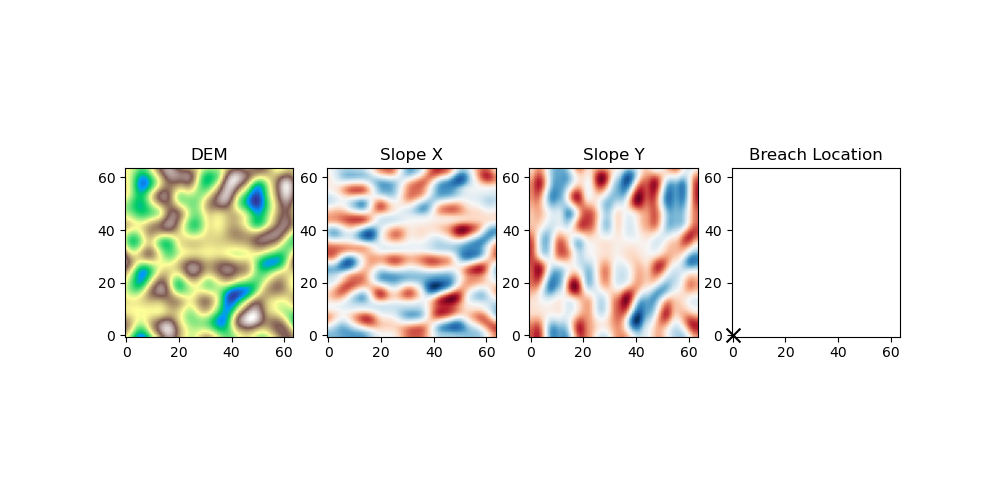

In [8]:
# From FAT application
fig, axs = plt.subplots(1, 4, figsize=(10, 5))

# specify which entry of the dataset to plot
numb = 0
inputs = train_dataset[numb][0][0]

axs[0].imshow(inputs[0].cpu(), cmap='terrain', origin='lower')
axs[0].set_title('DEM')

axs[1].imshow(inputs[1].cpu(), cmap='RdBu', origin='lower')
axs[1].set_title('Slope X')

axs[2].imshow(inputs[2].cpu(), cmap='RdBu', origin='lower')
axs[2].set_title('Slope Y')

non_zero_indices = torch.nonzero(inputs[3].cpu())
non_zero_row, non_zero_col = non_zero_indices[0][0].item(), non_zero_indices[0][1].item()
axs[3].imshow(inputs[3].cpu(), cmap='binary', origin='lower')
axs[3].set_title('Breach Location')
axs[3].scatter(non_zero_col, non_zero_row, color='k', marker='x', s=100,
                clip_on = False, clip_box = plt.gca().transData)
plt.show()

In [9]:
# Split dataset into train and validation
train_percnt = 0.8
train_size = int(train_percnt * len(train_dataset))
val_size = len(train_dataset) - train_size
train_set, val_set = random_split(train_dataset, [train_size, val_size])

In [10]:
# Normalize the inputs and outputs using training dataset
scaler_x, scaler_wd, scaler_q = scaler(train_set)

normalized_train_dataset = normalize_dataset(train_set, scaler_x, scaler_wd, scaler_q, train_val)
normalized_val_dataset = normalize_dataset(val_set, scaler_x, scaler_wd, scaler_q, train_val)

In [11]:
# Model
model = MultiStepConvLSTM(input_dim = normalized_train_dataset[0][0].shape[1],
                          output_dim = normalized_train_dataset[0][1].shape[1], 
                          hidden_dim = 8, kernel_size = (5, 5), num_layers = 4,
                          batch_first=True, bias=True, return_all_layers = False).to(device)

# model = ConvLSTM(input_dim = normalized_train_dataset[0][0].shape[1], output_dim = normalized_train_dataset[0][1].shape[1], hidden_dim = 32, kernel_size = (3, 3),
#                  num_layers = 48, batch_first=True, bias=True, return_all_layers = True).to(device)

In [12]:
model

MultiStepConvLSTM(
  (conv2): Conv2d(8, 2, kernel_size=(1, 1), stride=(1, 1))
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(12, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (1-3): 3 x ConvLSTMCell(
      (conv): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
)

In [13]:
num_parameters = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_parameters}")
model_size_MB = num_parameters * 4 / (1024 ** 2)  # Assuming float32 precision
print(f"Model size: {model_size_MB:.2f} MB")

Number of parameters: 48146
Model size: 0.18 MB


In [14]:
# Set training parameters
learning_rate = 0.0008 # largest learning_rate where the optimizer updates weights
batch_size = 8
# num_epochs = 3000
num_epochs = 500

# Create the optimizer to train the neural network via back-propagation
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# Create the training and validation dataloaders to "feed" data to the model in batches
train_loader = DataLoader(normalized_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(normalized_val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
train_losses = []
val_losses = []
count = 0
for epoch in range(1, num_epochs+1):
    train_loss = train_epoch_conv_lstm(model, train_loader, optimizer, device)

    val_loss = evaluation_conv_lstm(model, val_loader, device)

    if epoch == 1:
        best_loss = val_loss
    
    if val_loss<=best_loss:
        best_model = copy.deepcopy(model)
        best_loss = val_loss
        best_epoch = epoch
        count = 0

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    count += 1
    if epoch%10 == 0:
        print(f"Epoch: {epoch} " +
              f"\t Training loss: {train_loss: .2e} " + 
              f"\t Validation loss: {val_loss: .2e} " +
              f"\t Best validation loss: {best_loss: .2e}")
    stag_count = 100
    if count > stag_count:
        print(f"Loss Stagnated for {stag_count} epochs, early stopping initiated")
        break

Epoch: 10 	 Training loss:  3.01e-03 	 Validation loss:  2.87e-03 	 Best validation loss:  2.42e-03
Epoch: 20 	 Training loss:  2.17e-03 	 Validation loss:  2.01e-03 	 Best validation loss:  2.01e-03
Epoch: 30 	 Training loss:  2.44e-03 	 Validation loss:  2.12e-03 	 Best validation loss:  1.85e-03
Epoch: 40 	 Training loss:  1.55e-03 	 Validation loss:  1.60e-03 	 Best validation loss:  1.60e-03
Epoch: 50 	 Training loss:  1.36e-03 	 Validation loss:  1.56e-03 	 Best validation loss:  1.54e-03
Epoch: 60 	 Training loss:  1.21e-03 	 Validation loss:  1.38e-03 	 Best validation loss:  1.38e-03
Epoch: 70 	 Training loss:  2.96e-03 	 Validation loss:  2.99e-03 	 Best validation loss:  1.38e-03
Epoch: 80 	 Training loss:  2.05e-03 	 Validation loss:  1.97e-03 	 Best validation loss:  1.38e-03
Epoch: 90 	 Training loss:  2.31e-03 	 Validation loss:  2.27e-03 	 Best validation loss:  1.38e-03
Epoch: 100 	 Training loss:  1.66e-03 	 Validation loss:  1.84e-03 	 Best validation loss:  1.38e-03

In [ ]:
model = copy.deepcopy(best_model)
torch.save(model.state_dict(), save_path)

In [ ]:
plot_losses(train_losses, val_losses, 'MultiStepConvLSTM')

In [ ]:
plot_animation(20, normalized_train_dataset, model, train_val,
               scaler_x, scaler_wd, scaler_q, device = device, save = False)